### **Install and Import dependencies**

In [ ]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.5
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.4.1
arviz                            0.15.1
astropy                          5.3.3
astunparse                       1.6.3
async-timeout                    4.0.3
attrs                            23.1.0
audioread                        3.0.0
autograd                         1.6.2
Babel                            2.12.1
backcall                         0.2.0
beautifulsoup4                   4.11.2
bleach                           6.0.0
blinker                          1.4
bl

In [ ]:
import os
import cv2
import imageio
import numpy as np
import tensorflow as tf

from typing import List
from matplotlib import pyplot as plt

In [ ]:
physical_devices = tf.config.list_physical_devices("GPU")

try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass

### **Build data loading functions**

In [ ]:
import gdown

In [ ]:
url = "https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL"
output = "data.zip"

gdown.download(url, output, quiet=False)
gdown.extractall("data.zip")

Downloading...
From: https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
To: /content/data.zip
100%|██████████| 423M/423M [00:10<00:00, 40.4MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [ ]:
def load_video(path:str) -> List[float]:
  """
  Takes a video path as input and returns a list containing each frame's lips
  feature in floatonic representation.
  """
  cap = cv2.VideoCapture(path)
  frames = []

  for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret, frame = cap.read()
    frame = tf.image.rgb_to_grayscale(frame)
    frames.append(frame[190:236, 80:220, :])

  cap.release()

  mean = tf.math.reduce_mean(frames)
  std = tf.math.reduce_std(tf.cast(frames, tf.float32))
  return tf.cast((frames-mean), tf.float32) / std

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary = vocab,
                                           oov_token = "")
num_to_char = tf.keras.layers.StringLookup(vocabulary = char_to_num.get_vocabulary(),
                                           oov_token = "", invert = True)

print(f"Vocabulary: {char_to_num.get_vocabulary()} "
      f"(Size: {char_to_num.vocabulary_size()})")

Vocabulary: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (Size: 40)


In [ ]:
char_to_num(['p', 'a', 'r', 'a', 's'])

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([16,  1, 18,  1, 19])>

In [ ]:
num_to_char([16,  1, 18,  1, 19])

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'p', b'a', b'r', b'a', b's'], dtype=object)>

In [ ]:
def load_alignments(path: str) -> List[str]:
  """
  Takes path to alignment file as input, extracts the word and returns the
  list with numeric encondings of extracted words
  """
  with open(path, 'r') as f:
    lines = f.readlines()

  tokens = []

  for line in lines:
    line = line.split()

    if line[2] != "sil":
      tokens = [*tokens, ' ', line[2]]

  return char_to_num(tf.reshape(tf.strings.unicode_split(tokens,
                                                         input_encoding = 'UTF-8'), (-1)))[1:]

In [ ]:
def load_data(path:str):
  """
  Takes folder path as input and returns list of pre-processed frames & alignments
  """
  path = bytes.decode(path.numpy())

  file_name = path.split('/')[-1].split('.')[0]
  video_path = os.path.join('data', 's1', f'{file_name}.mpg')
  alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
  frames = load_video(video_path)
  alignments = load_alignments(alignment_path)

  return frames, alignments

In [ ]:
test_path = "./data/s1/bbaf2n.mpg"

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [ ]:
frames

<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
array([[[[1.4991663 ],
         [1.4991663 ],
         [1.4616871 ],
         ...,
         [0.41227072],
         [0.41227072],
         [0.41227072]],

        [[1.4991663 ],
         [1.4991663 ],
         [1.4616871 ],
         ...,
         [0.41227072],
         [0.41227072],
         [0.41227072]],

        [[1.4616871 ],
         [1.4616871 ],
         [1.4991663 ],
         ...,
         [0.3373124 ],
         [0.3373124 ],
         [0.3373124 ]],

        ...,

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.11243746],
         [0.11243746],
         [0.07495831]],

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.11243746],
         [0.07495831],
         [0.07495831]],

        [[1.0494163 ],
         [1.0494163 ],
         [1.0119373 ],
         ...,
         [0.07495831],
         [0.07495831],
         [0.03747915]]],


  

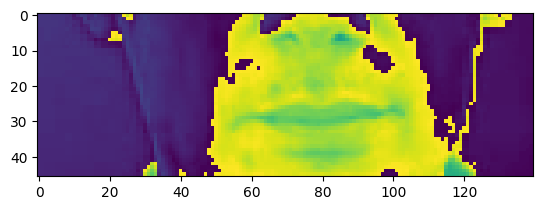

In [ ]:
plt.imshow(frames[1])

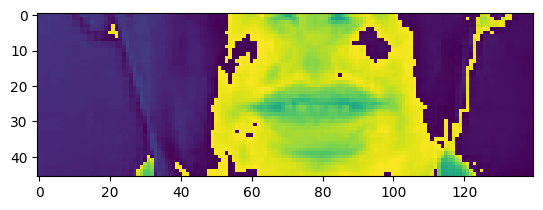

In [ ]:
plt.imshow(frames[20])

In [ ]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23])>

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

In [ ]:
def mappable_function(path: str) -> List[str]:
  """
  Takes path as an input : Mapper func that uses `tf.py_function` to deal with
  pure string processing
  """
  result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
  return result

### **Create Data Pipeline**

In [ ]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes = ([75, None, None, None], [40]))
data = data.prefetch(tf.data.AUTOTUNE)

train = data.take(450)
test = data.skip(450)

In [ ]:
frames, alignments = data.as_numpy_iterator().next()

In [ ]:
frames

array([[[[[1.3981657 ],
          [1.3981657 ],
          [1.4370036 ],
          ...,
          [0.2330276 ],
          [9.748322  ],
          [9.321104  ]],

         [[1.3981657 ],
          [1.3981657 ],
          [1.4370036 ],
          ...,
          [9.825997  ],
          [9.437618  ],
          [9.515294  ]],

         [[1.3981657 ],
          [1.3981657 ],
          [1.3981657 ],
          ...,
          [9.670646  ],
          [9.78716   ],
          [9.631807  ]],

         ...,

         [[0.9321104 ],
          [0.9321104 ],
          [0.9321104 ],
          ...,
          [9.825997  ],
          [9.78716   ],
          [9.78716   ]],

         [[0.9321104 ],
          [0.9321104 ],
          [0.9321104 ],
          ...,
          [9.903673  ],
          [9.864836  ],
          [9.864836  ]],

         [[0.9321104 ],
          [0.9321104 ],
          [0.9321104 ],
          ...,
          [9.903673  ],
          [9.864836  ],
          [9.825997  ]]],


        [[[1.3981

In [ ]:
len(frames)

2

In [ ]:
alignments

array([[ 2,  9, 14, 39,  2, 12, 21,  5, 39,  2, 25, 39,  6, 39, 14,  9,
        14,  5, 39,  1,  7,  1,  9, 14,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [19,  5, 20, 39, 23,  8,  9, 20,  5, 39,  1, 20, 39,  9, 39, 26,
         5, 18, 15, 39, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [ ]:
len(alignments)

2

In [ ]:
test = data.as_numpy_iterator()
val = test.next(); val[0]

array([[[[[1.4877532 ],
          [1.4877532 ],
          [1.4877532 ],
          ...,
          [0.36286664],
          [0.2902933 ],
          [0.2902933 ]],

         [[1.4514666 ],
          [1.4514666 ],
          [1.4877532 ],
          ...,
          [0.36286664],
          [0.2902933 ],
          [0.2902933 ]],

         [[1.4877532 ],
          [1.4877532 ],
          [1.4151798 ],
          ...,
          [0.3991533 ],
          [0.32657996],
          [0.32657996]],

         ...,

         [[1.0160266 ],
          [1.0160266 ],
          [1.0160266 ],
          ...,
          [0.14514665],
          [0.14514665],
          [0.10885999]],

         [[0.9797399 ],
          [0.9797399 ],
          [0.9797399 ],
          ...,
          [0.14514665],
          [0.10885999],
          [0.10885999]],

         [[0.9797399 ],
          [0.9797399 ],
          [0.9797399 ],
          ...,
          [0.10885999],
          [0.10885999],
          [0.07257333]]],


        [[[1.5240

In [ ]:
val[0][0]

array([[[[1.4877532 ],
         [1.4877532 ],
         [1.4877532 ],
         ...,
         [0.36286664],
         [0.2902933 ],
         [0.2902933 ]],

        [[1.4514666 ],
         [1.4514666 ],
         [1.4877532 ],
         ...,
         [0.36286664],
         [0.2902933 ],
         [0.2902933 ]],

        [[1.4877532 ],
         [1.4877532 ],
         [1.4151798 ],
         ...,
         [0.3991533 ],
         [0.32657996],
         [0.32657996]],

        ...,

        [[1.0160266 ],
         [1.0160266 ],
         [1.0160266 ],
         ...,
         [0.14514665],
         [0.14514665],
         [0.10885999]],

        [[0.9797399 ],
         [0.9797399 ],
         [0.9797399 ],
         ...,
         [0.14514665],
         [0.10885999],
         [0.10885999]],

        [[0.9797399 ],
         [0.9797399 ],
         [0.9797399 ],
         ...,
         [0.10885999],
         [0.10885999],
         [0.07257333]]],


       [[[1.5240399 ],
         [1.4877532 ],
         [1.45

In [ ]:
imageio.mimsave('./Animation.gif', val[0][0], fps=10)

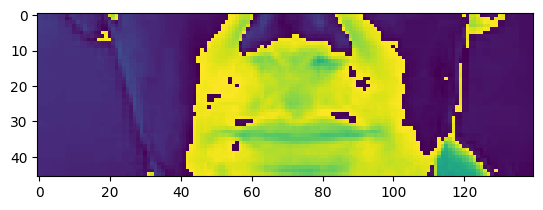

In [ ]:
plt.imshow(val[0][0][74])

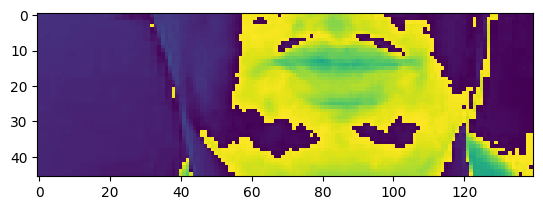

In [ ]:
plt.imshow(val[0][1][29])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place white in p six now'>

### **Design the Deep Neural Network**

In [ ]:
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [ ]:
yhat = model.predict(val[0])

1/1 [==============================] - 9s 9s/step


In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'xdddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddddr'>

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

### **Setup Training Options & Train**

In [ ]:
def scheduler(epoch, lr):
  if epoch < 30:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
  batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
  input_len = tf.cast(tf.shape(y_pred)[0], dtype="int64")
  label_len = tf.cast(tf.shape(y_true)[0], dtype="int64")

  input_len *= tf.ones(shape=(batch_len, 1), dtype="int64")
  label_len *= tf.ones(shape=(batch_len, 1), dtype="int64")

  loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_len, label_len)
  return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
  def __init__(self, dataset) -> None:
    self.dataset = dataset.as_numpy_iterator()

  def on_epoch_end(self, epoch, logs=None) -> None:
    data = self.dataset.next()
    yhat = self.model.predict(data[0])
    decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()

    for x in range(len(yhat)):
      print("Original: ", tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
      print("Prediction: ", tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
      print("~"*100)

In [ ]:
model.compile(optimizer = Adam(learning_rate=0.0001),
              loss = CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models', 'checkpoint'),
                                      monitor='loss',
                                      save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(data)

In [ ]:
model.fit(train,
          validation_data=test,
          epochs=100,
          callbacks=[checkpoint_callback, schedule_callback, example_callback])

### **Make a Prediction**

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'LipNet Models')

Downloading...
From: https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:00<00:00, 101MB/s]


['LipNet Models/checkpoint.index',
 'LipNet Models/__MACOSX/._checkpoint.index',
 'LipNet Models/checkpoint.data-00000-of-00001',
 'LipNet Models/__MACOSX/._checkpoint.data-00000-of-00001',
 'LipNet Models/checkpoint',
 'LipNet Models/__MACOSX/._checkpoint']

In [ ]:
model.load_weights('./LipNet Models/checkpoint')

In [ ]:
data = data.shuffle(500)
test_data = data.as_numpy_iterator()
test_data.next()

In [ ]:
sample = test_data.next()
yhat = model.predict(sample[0])

1/1 [==============================] - 0s 283ms/step


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()

In [ ]:
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red with t six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay red at y four now'>]